## 1.Initialization

Newton's second law for the classical mass spring smaper system.

$m\ddot{x} = - c\dot{x} - kx$

We make the substitution

$\dot{x} = v$

and write system in state space form,

$\dot{x} = v\\
\dot{v} = - \frac{c}{m}v - \frac{k}{m}x.$

In this case we neglect damping, meaning that

$c = 0$

resulting in the final system in state space form,

$\dot{x} = v\\
\dot{v} =  - \frac{k}{m}x.$

In [751]:
import numpy as np
import pysindy as ps

from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

In [752]:
#initialization

dt = .1 #integtration time step
t = np.arange(0, 100, dt) #integration length

#x_0 = np.array([1,0,0])  #Initial state of observer in the form [x1_0,x2_dot_0,z]
#y_0 = np.array([-1,0,2])  #Initial state of feature in the form [y1_0,y2_dot_0,z]




### Generate data for the Observer.

In [753]:
param_1 = 1 #Observer parameter k/m

def observer(x, t): #Observer System
    return [
        x[1], #x_1 dot
        -param_1*x[0]] #x_2 dot

x_0 = [1, 0]  # Observer Initial Conditions
x_3 = 0 #third dimension used to calculate distance between observer and feature

x = odeint(observer, x_0, t) # Generate measurement data in form [x1, x2]
x




array([[ 1.        ,  0.        ],
       [ 0.99500417, -0.0998334 ],
       [ 0.98006658, -0.19866932],
       ...,
       [ 0.67416391,  0.73858386],
       [ 0.74453125,  0.66758994],
       [ 0.80745948,  0.58992567]])

### Generate date for the Feature.

In [754]:
param_2 = 1.05 #Feature parameter k/m

def feature(y, t): #Feature System
    return [
        y[1], #y1 dot
        -param_2*y[0]] #y2 dot

y_0 = [-1, 0] # Observer Initial Conditions
y_3 = 1 # distance from observer

y = odeint(feature, y_0, t) # Generate measurement data in form [y1, y2]
y

array([[-1.        ,  0.        ],
       [-0.99475459,  0.10481633],
       [-0.9790734 ,  0.20853307],
       ...,
       [ 0.06030067,  1.02283204],
       [ 0.16208867,  1.01114637],
       [ 0.26217623,  0.98885295]])

<ipython-input-755-5aa398db1b5d>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


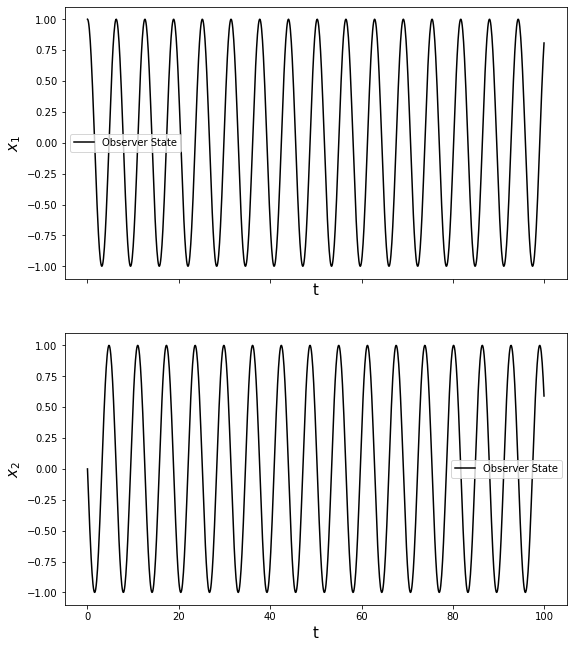

In [755]:
fig, axs = plt.subplots(x.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(x.shape[1]):
    axs[i].plot(t, x[:, i], 'k', label='Observer State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig.show()

<ipython-input-756-38370a67842b>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


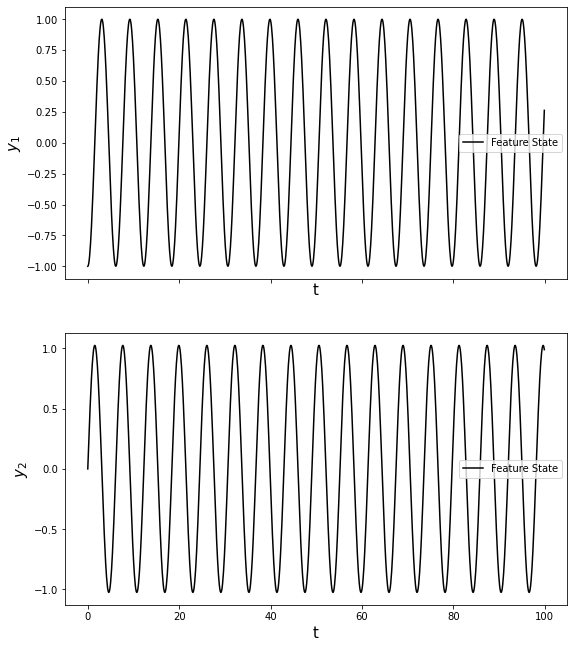

In [756]:
fig, axs = plt.subplots(y.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(y.shape[1]):
    axs[i].plot(t, y[:, i], 'k', label='Feature State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$y_{}$'.format(i+1), fontsize = 15)
fig.show()

## 2.Simulate Sensors
### Observer IMU sensor simulation

In [757]:
acc = -param_1*x[:,0]
acc

#Stochastic IMU sensor
imu_mean = 0
imu_std = 0.1

acc_noise = acc+np.random.normal(imu_mean,imu_std,size=acc.shape)



### Relative position sensor simulation

In [758]:
# Nominal Sensor on the observer
delta = y-x
delta

#Stochastic sensor on the observer
rel_sense_mean = 0 #mean of relative measurement sensor
rel_sense_std = (x[0,0]-y[0,0]) * 0.3 #standard deviation of relative measurement scales with the distance

delta_noise = delta + np.random.normal(rel_sense_mean,rel_sense_std,size=delta.shape)




## 3.Learn Relative Dynamics
### Define SINDy options

In [759]:
differentiation_method = ps.FiniteDifference(order=2)

optimizer = ps.STLSQ(threshold=0.2)
lasso_optimizer = Lasso(alpha=0.001, max_iter=2000, fit_intercept=False)
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
identity_library = ps.IdentityLibrary()
combined_library = poly_library #+ identity_library #+ fourier_library

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=combined_library,
    optimizer=sr3_optimizer)




### Learn Relative Dynamics from Relative State Sensor
#### -Learn model using SINDy on nominal data
#### -Compare actual relative dynamics to learned relative dynamics

x0' = 0.998 x1
x1' = -1.023 x0
Model score: 0.999826
<ipython-input-760-cdeffdb274a0>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


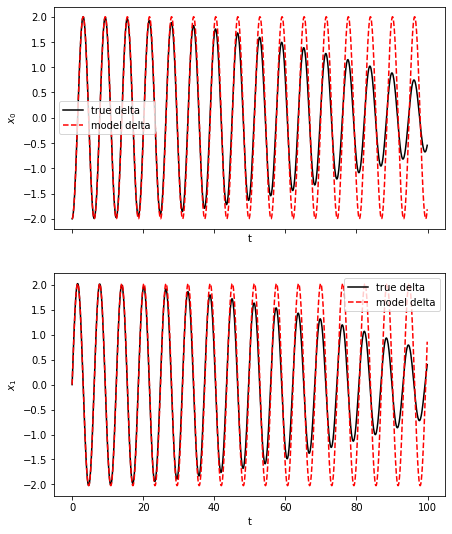

In [760]:
model.fit(delta, t=dt)
model.print()
print('Model score: %f' % model.score(delta, t=dt))

delta_0 = [-2, 0]
delta_sim = model.simulate(delta_0, t)

fig, axs = plt.subplots(delta.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(delta.shape[1]):
    axs[i].plot(t, delta[:, i], 'k', label='true delta')
    axs[i].plot(t, delta_sim[:, i], 'r--', label='model delta')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()




### -Learn model using SINDy on noisy data
### -Compare actual relative dynamics to learned relative dynamics

x0' = 0.998 x1
x1' = -1.023 x0
Model score: 0.042171
<ipython-input-761-cd5b55406280>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


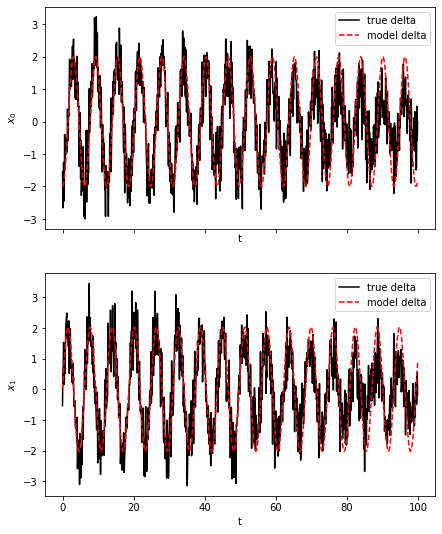

In [761]:
model.fit(delta, t=dt)
model.print()
print('Model score: %f' % model.score(delta_noise, t=dt))

delta_0 = [-2, 0]
delta_sim = model.simulate(delta_0, t)

fig, axs = plt.subplots(delta_noise.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(delta.shape[1]):
    axs[i].plot(t, delta_noise[:, i], 'k', label='true delta')
    axs[i].plot(t, delta_sim[:, i], 'r--', label='model delta')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()




## 4.Observer State Estimation
### Dead Reckoning with noisy IMU 

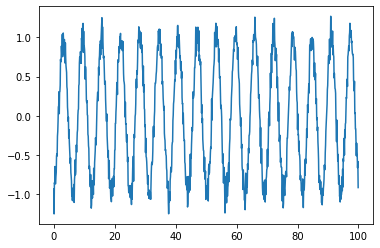

In [775]:
plt.plot(t,acc_noise) #acceleration of observer over time

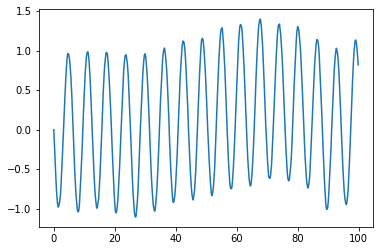

In [762]:
vel_noise = np.zeros(acc_noise.size-1)

#Integrate Acceleration
for x in range(1,vel_noise.size):
    vel_noise[x] = acc_noise[x-1]*dt+vel_noise[x-1]

plt.plot(t[0:vel_noise.size],vel_noise) # velocity of observer over time
#vel_noise

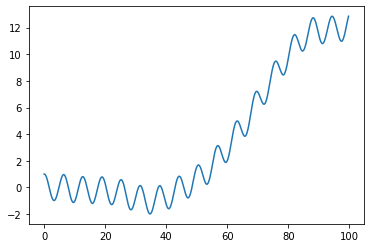

In [763]:
pos_noise = np.zeros(vel_noise.size-1)
pos_noise[0] = x_0[0]
#Integrate Acceleration
for x in range(1,pos_noise.size):

    pos_noise[x] = vel_noise[x-1]*dt+pos_noise[x-1]

plt.plot(t[0:pos_noise.size],pos_noise) # velocity of observer over time


### Feature in the global frame using the dead reckoning est

In [764]:
delta_state = delta_sim[t.size-1]
x_proc = [pos_noise[pos_noise.size-1],vel_noise[vel_noise.size-1]]

y_state_est = delta_state + x_proc
y_state_est

array([11.04414304,  1.68054657])

In [765]:
y[t.size-1]

array([0.26217623, 0.98885295])

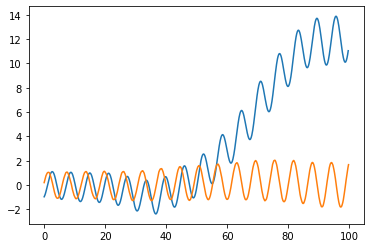

In [766]:
y1_est = delta_sim[2:,0]+ pos_noise
y2_est = delta_sim[1:,1]+ vel_noise

plt.plot(t[0:pos_noise.size],y1_est)
plt.plot(t[0:vel_noise.size],y2_est)

### Estimated relative state vs measure relative state

In [767]:
delta_sim[len(delta_sim)-1]

array([-1.81083824,  0.85960334])

In [768]:
delta_noise[len(delta_noise)-1]
delta_noise

array([[-1.55743320e+00, -5.37374471e-01],
       [-2.09990146e+00,  5.43019670e-01],
       [-2.65879230e+00,  7.32387756e-01],
       ...,
       [ 4.72358729e-01, -2.93492404e-01],
       [-5.85990312e-01,  5.44662275e-01],
       [-1.89363535e-03, -1.80568962e-01]])

In [769]:
delta_est = delta_sim[len(delta_sim)-1]-delta_noise[len(delta_noise)-1]
delta_est

array([-1.8089446 ,  1.04017231])

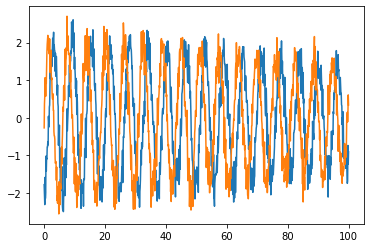

In [770]:
plt.plot(t,(delta_sim+delta_noise)/2)

#x_cor=((delta_sim-delta_noise)+x_proc)/2
#plt.plot(t,x_cor)

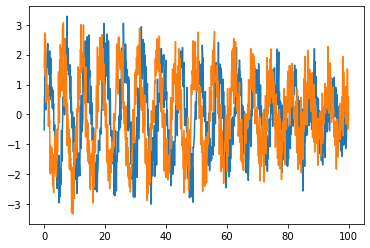

In [774]:
F = np.array([[0,-1.025],[0.9518,0]])
# = np.array([[0,1],[-1.025,0]])
x_cor = delta_noise.dot(F)

#x_cor=np.linalg.lstsq(F, np.transpose(delta_noise))
plt.plot(t,x_cor)
